## Testowanie Sensor Fusion

narazie na danych z części Bag

### Wczytanie + testowanie

#### Wczytywanie danych

In [1]:
import pandas as pd
import glob
import os

dir_path = 'D:/sussex/train/Bag'

# Get all training data (all .txt files except the Label.txt)
sensor_files = [
    f for f in glob.glob(os.path.join(dir_path, '*.txt'))
    if os.path.basename(f).lower() != 'label.txt'
]

# Read each file into a DataFrame and store in a dictionary
sensor_data = {}
for file in sensor_files:
    key = os.path.splitext(os.path.basename(file))[0]  # e.g., 'Acc_x'
    sensor_data[key] = pd.read_csv(file, sep=r'\s+', header=None)

# Quick summary of what was loaded
for name, df in sensor_data.items():
    print(f"{name}: {df.shape}")


Acc_solo_x: (196072, 500)
Acc_solo_y: (196072, 500)
Acc_solo_z: (196072, 500)
Acc_x: (196072, 500)
Acc_y: (196072, 500)
Acc_z: (196072, 500)
Gyr_x: (196072, 500)
Gyr_y: (196072, 500)
Gyr_z: (196072, 500)
Mag_x: (196072, 500)
Mag_y: (196072, 500)
Mag_z: (196072, 500)


In [2]:
import numpy as np
# Path to the Label.txt file
label_path = 'D:/sussex/train/Bag/Label.txt'

# Load the labels (500 columns per row, no header)
df_labels = pd.read_csv(label_path, sep=r'\s+', header=None)

print(f"Labels: {df_labels.shape}")

Labels: (196072, 500)


In [3]:
labels_dict = {
    1: "Still",
    2: "Walking",
    3: "Run",
    4: "Bike",
    5: "Bus",
    6: "Car",
    7: "Train",
    8: "Subway"
}

In [4]:
import numpy as np

labels = df_labels
unique_labels = {}
valid_indices = []


def get_label(labels):
    # Overall label as the most common label in the window
    unique_elements, counts = np.unique(labels, return_counts=True)
    max_index = np.argmax(counts)
    most_common_label = unique_elements[max_index]
    
    return most_common_label

# Iterate through each row in the labels array
for i in range(labels.shape[0]):
    label = get_label(df_labels.iloc[i])
    if label not in unique_labels:
            unique_labels[label] = i 
            valid_indices.append([f"{labels_dict[label]}", i])

print("Valid indices for each represented label:", valid_indices)

Valid indices for each represented label: [['Bike', 0], ['Train', 96], ['Walking', 1530], ['Still', 1581], ['Subway', 1800], ['Run', 9402], ['Car', 10028], ['Bus', 30561]]


In [5]:
probes = {
    "Bike": 0,
    "Train": 96,
    "Walking": 1530,
    "Still": 1581,
    "Subway": 1800,
    "Run": 9402,
    "Car": 10028,
    "Bus": 30561
}

#### Funkcje do testowania


In [6]:
def run_over_row(row_index, function):
    label_row = df_labels.iloc[row_index]
    sensor_values = {}
    
    for sensor_name, df in sensor_data.items():
        sensor_values[sensor_name] = df.iloc[row_index].values
    
    return function(label_row, sensor_values)

def run_over_dataset(function):
    results = []
    for row_index in range(df_labels.shape[0]):
        label, result = run_over_row(row_index, function)
        results.append([label, result])

    return results

def get_label(labels):
    # Overall label as the most common label in the window
    unique_elements, counts = np.unique(labels, return_counts=True)
    max_index = np.argmax(counts)
    most_common_label = unique_elements[max_index]
    
    return most_common_label

In [6]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


#### Testowe wizualizacje

heatmapa z możliwością wybrania metody agregacji danych w oknie czasowym

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap_of(data, function, labels):
    
    results = {i: [] for i in range(1, 9)}

    # Aggregation in the time windows
    for point in data:
        results[point[0]].append(function(point[1], axis=0))

    means_dict = {}

    # Aggregation per category
    for key in results:
        if results[key]:
            data_array = np.array(results[key])
            data_array = data_array[~np.isnan(data_array).any(axis=1)]
            means = np.mean(data_array, axis=0) 
            means_dict[key] = means 

    means_array = np.array(list(means_dict.values()))
    means_df = pd.DataFrame(means_array, index=means_dict.keys(), columns=labels)

    means_df.index = [labels_dict.get(i, f"Unknown {i}") for i in means_df.index]

    # Create a heatmap
    plt.figure(figsize=(10, 4))
    sns.heatmap(means_df.T, annot=True, fmt=".2f", cmap='viridis', cbar=True)
    plt.title('Heatmap of Mean Results')
    plt.xlabel('Labels')
    plt.ylabel('Parameters')
    plt.show()

histogramy dla kategorii

In [8]:
import matplotlib.pyplot as plt

def histograms_of(data, function, name):
    
    results = {i: [] for i in range(1, 9)}

    # Aggregation in the time windows
    for point in data:
        if point[1].ndim == 0:
            results[point[0]].append(point[1])
        else:
            results[point[0]].append(function(point[1], axis=0))

    for k in results:
        results[k] = np.array(results[k]).flatten()

    # Display histograms
    fig, axes = plt.subplots(2, 4, figsize=(18, 6))
    axes = axes.flatten()

    for i in range(8):
        ax = axes[i]
        ax.hist(results[i+1], bins=20, color='skyblue', edgecolor='black')
        ax.set_title(f"{labels_dict[i + 1]}")
        ax.grid(True)
    
    fig.suptitle(f"Distribution of {name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Próbne implementacje

#### Fusion/imufusion
Open sourceowa biblioteka implementująca algorytm AHRS, określa zmiany w orientacji urządzenia względem Ziemi na podstawie akcelerometru + żyrokskopu + magnetometru

https://github.com/xioTechnologies/Fusion/tree/main

<img src="https://www.linearmotiontips.com/wp-content/uploads/2020/05/Roll-Pitch-Yaw.jpg" alt="drawing" width="400"/>

In [13]:
%pip install imufusion

Note: you may need to restart the kernel to use updated packages.


In [9]:
def mirror_me(arr):
    mirrored_arr = np.vstack((arr[::-1], arr))

    return mirrored_arr

In [10]:
import imufusion

def euler_angles(labels, sensors):
    fs = 1/100
    recording_length = 500

    euler = np.empty((recording_length, 3))
    ahrs = imufusion.Ahrs()

    acc = np.concatenate((mirror_me(sensors["Acc_x"].reshape(500, 1)), mirror_me(sensors["Acc_y"].reshape(500, 1)), mirror_me(sensors["Acc_z"].reshape(500, 1))), axis=1)
    gyr = np.concatenate((mirror_me(sensors["Gyr_x"].reshape(500, 1)), mirror_me(sensors["Gyr_y"].reshape(500, 1)), mirror_me(sensors["Gyr_z"].reshape(500, 1))), axis=1)
    mag = np.concatenate((mirror_me(sensors["Mag_x"].reshape(500, 1)), mirror_me(sensors["Mag_y"].reshape(500, 1)), mirror_me(sensors["Mag_z"].reshape(500, 1))), axis=1)

    print(acc.shape)

    for index in range(recording_length * 2):
        ahrs.update(gyr[index], acc[index], mag[index], fs)
        if index >= recording_length:
            euler[index - recording_length] = ahrs.quaternion.to_euler()

    label = get_label(labels)

    return label, euler

(1000, 3)


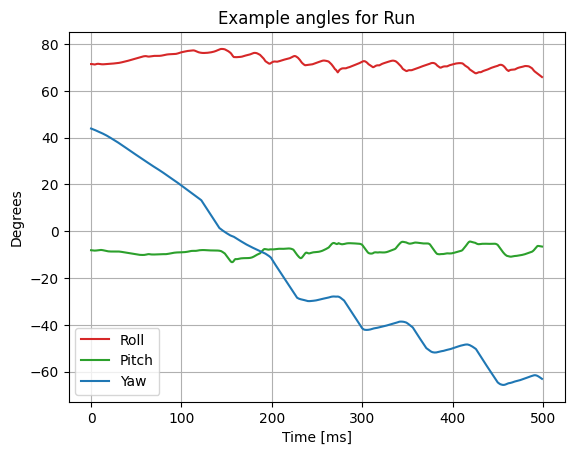

In [11]:
import matplotlib.pyplot as plt

label, eulers = run_over_row(probes["Run"], euler_angles)

plt.plot(eulers[:, 0], "tab:red", label="Roll")
plt.plot(eulers[:, 1], "tab:green", label="Pitch")
plt.plot(eulers[:, 2], "tab:blue", label="Yaw")
plt.title(f"Example angles for {labels_dict[label]}")
plt.xlabel("Time [ms]")
plt.ylabel("Degrees")
plt.grid()
plt.legend()

plt.show()

In [ ]:
results = run_over_dataset(euler_angles)

Mean of means


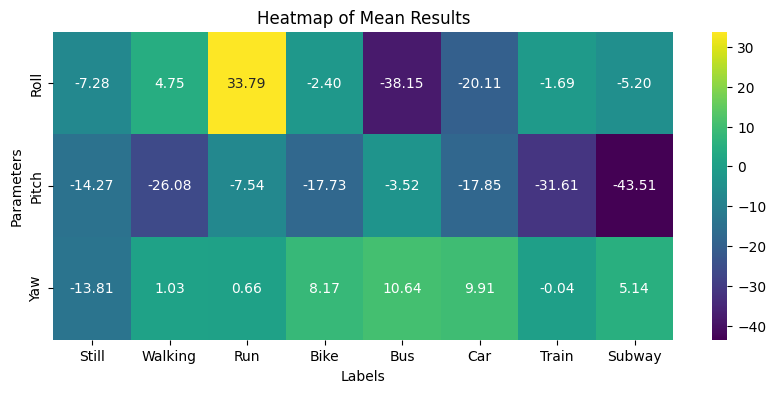

Mean of medians


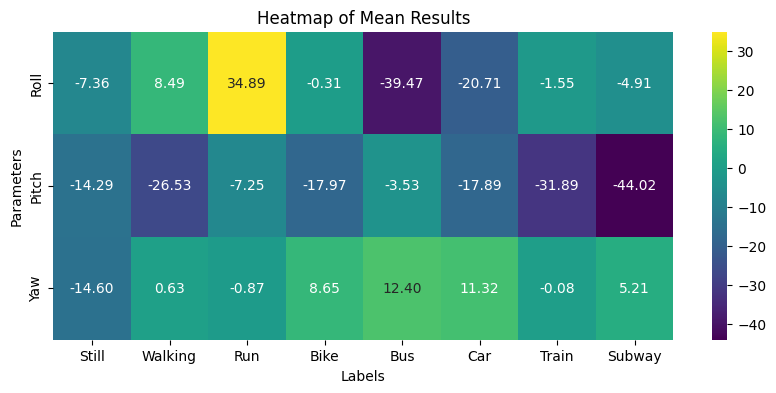

Mean of std


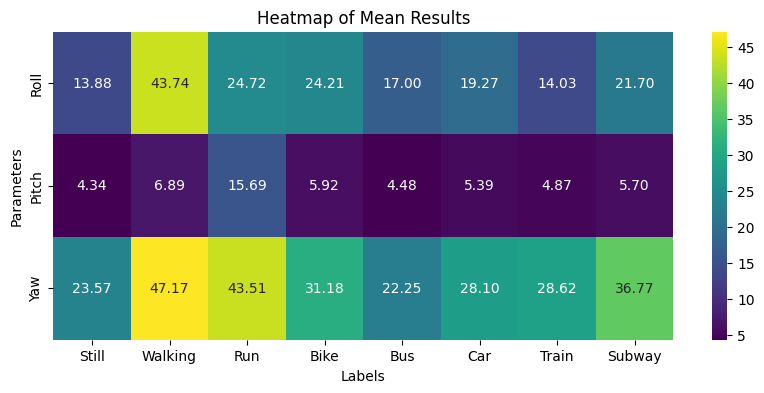

Mean of max


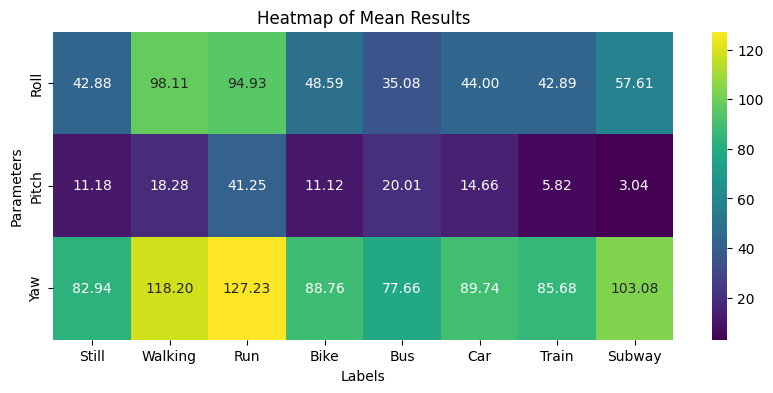

Mean of min


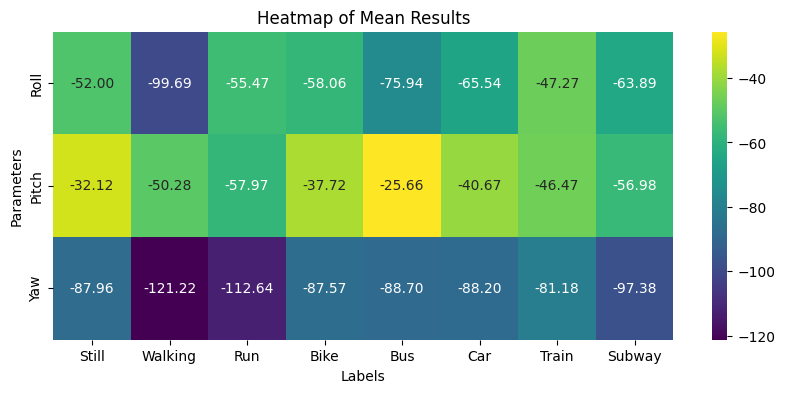

In [133]:
print("Mean of means")
heatmap_of(results, np.mean, ["Roll", "Pitch", "Yaw"])
print("Mean of medians")
heatmap_of(results, np.median, ["Roll", "Pitch", "Yaw"])
print("Mean of std")
heatmap_of(results, np.std, ["Roll", "Pitch", "Yaw"])
print("Mean of max")
heatmap_of(results, np.max, ["Roll", "Pitch", "Yaw"])
print("Mean of min")
heatmap_of(results, np.min, ["Roll", "Pitch", "Yaw"])

#### Reprezentacja kwaternionowa
<img src="https://danceswithcode.net/engineeringnotes/quaternions/images/axis-angle.png" alt="drawing" width="400"/>

In [12]:
import imufusion

def quat_angles(labels, sensors):
    fs = 1/100
    recording_length = 500

    quat = np.empty((recording_length, 4))
    ahrs = imufusion.Ahrs()

    acc = np.concatenate((mirror_me(sensors["Acc_x"].reshape(500, 1)), mirror_me(sensors["Acc_y"].reshape(500, 1)), mirror_me(sensors["Acc_z"].reshape(500, 1))), axis=1)
    gyr = np.concatenate((mirror_me(sensors["Gyr_x"].reshape(500, 1)), mirror_me(sensors["Gyr_y"].reshape(500, 1)), mirror_me(sensors["Gyr_z"].reshape(500, 1))), axis=1)
    mag = np.concatenate((mirror_me(sensors["Mag_x"].reshape(500, 1)), mirror_me(sensors["Mag_y"].reshape(500, 1)), mirror_me(sensors["Mag_z"].reshape(500, 1))), axis=1)

    for index in range(recording_length * 2):
        ahrs.update(gyr[index], acc[index], mag[index], fs)
        if index >= recording_length:
            quat[index - recording_length] = [ahrs.quaternion.x, ahrs.quaternion.y, ahrs.quaternion.z, ahrs.quaternion.w]

    label = get_label(labels)

    return label, quat

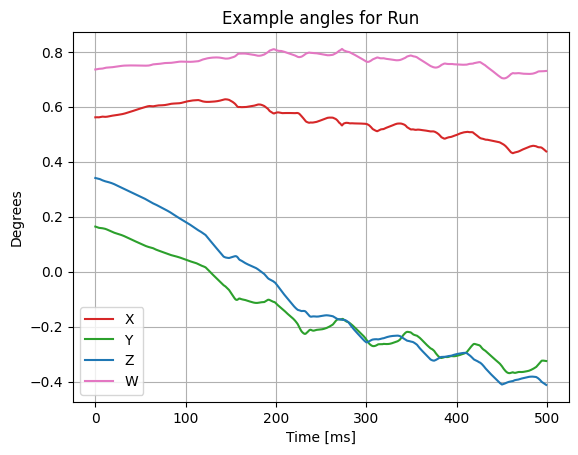

In [13]:
import matplotlib.pyplot as plt

label, quat = run_over_row(probes["Run"], quat_angles)

plt.plot(quat[:, 0], "tab:red", label="X")
plt.plot(quat[:, 1], "tab:green", label="Y")
plt.plot(quat[:, 2], "tab:blue", label="Z")
plt.plot(quat[:, 3], "tab:pink", label="W")
plt.title(f"Example angles for {labels_dict[label]}")
plt.xlabel("Time [ms]")
plt.ylabel("Degrees")
plt.grid()
plt.legend()

In [47]:
results = run_over_dataset(quat_angles)

Mean of means


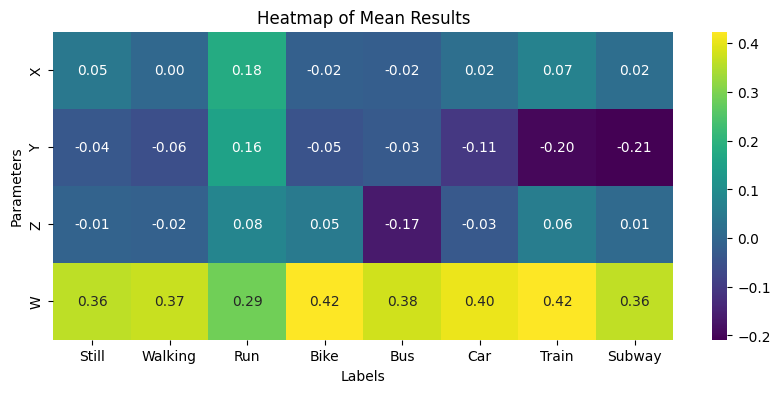

Mean of medians


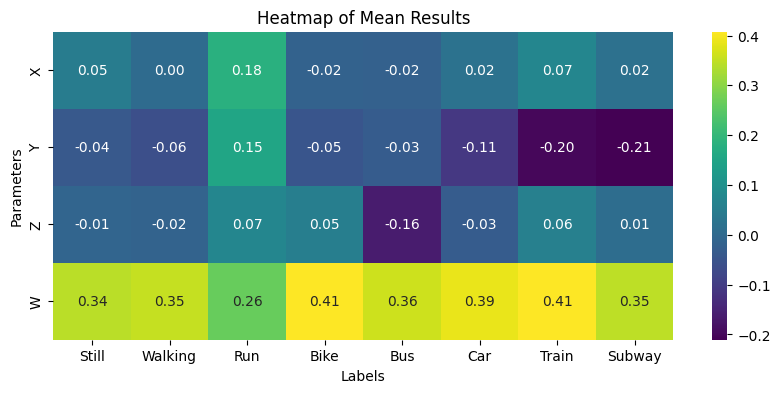

Mean of std


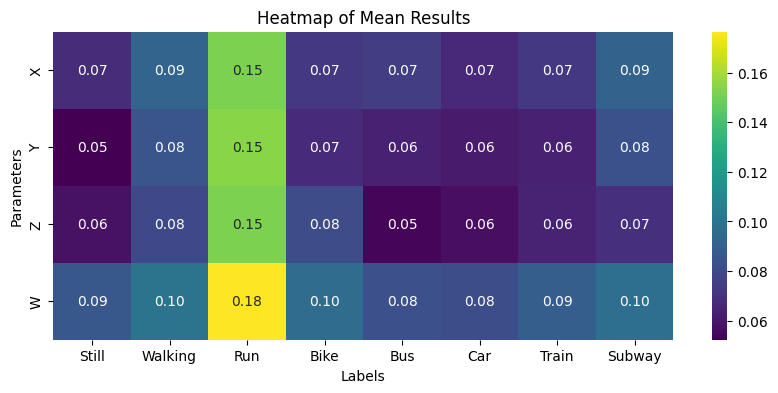

Mean of max


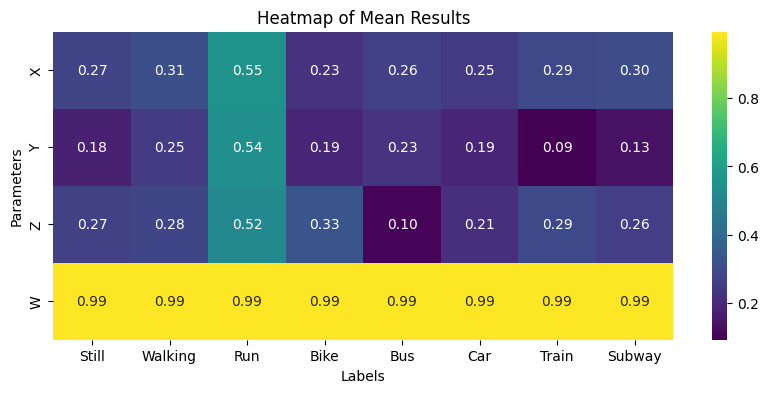

Mean of min


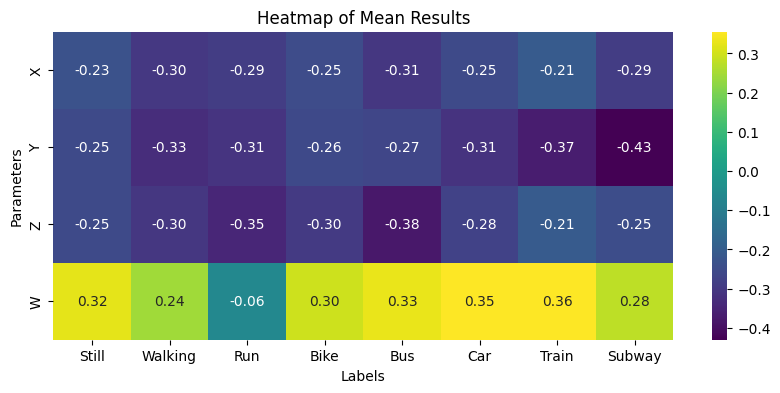

In [49]:
print("Mean of means")
heatmap_of(results, np.mean, ["X", "Y", "Z", "W"])
print("Mean of medians")
heatmap_of(results, np.median, ["X", "Y", "Z", "W"])
print("Mean of std")
heatmap_of(results, np.std, ["X", "Y", "Z", "W"])
print("Mean of max")
heatmap_of(results, np.max, ["X", "Y", "Z", "W"])
print("Mean of min")
heatmap_of(results, np.min, ["X", "Y", "Z", "W"])

#### Rozdzielenie czynnika grawitacyjnego od przyspieszenia linowego

0, 1, 2 - nieprzefiltrowane
3, 4, 5 - usunięte g

In [14]:
import imufusion
from scipy.spatial.transform import Rotation as R
import scipy


def acc_g_separation(labels, sensors):
    fs = 1/100
    recording_length = 500

    lin_acc = np.empty((recording_length, 6))
    ahrs = imufusion.Ahrs()

    acc = np.concatenate((mirror_me(sensors["Acc_x"].reshape(500, 1)), mirror_me(sensors["Acc_y"].reshape(500, 1)), mirror_me(sensors["Acc_z"].reshape(500, 1))), axis=1)
    gyr = np.concatenate((mirror_me(sensors["Gyr_x"].reshape(500, 1)), mirror_me(sensors["Gyr_y"].reshape(500, 1)), mirror_me(sensors["Gyr_z"].reshape(500, 1))), axis=1)
    mag = np.concatenate((mirror_me(sensors["Mag_x"].reshape(500, 1)), mirror_me(sensors["Mag_y"].reshape(500, 1)), mirror_me(sensors["Mag_z"].reshape(500, 1))), axis=1)
    
    last_rot = R.from_quat([0,0,0,1])

    for index in range(recording_length * 2):
        ahrs.update(gyr[index], acc[index], mag[index], fs)

        q = [ahrs.quaternion.x, ahrs.quaternion.y, ahrs.quaternion.z, ahrs.quaternion.w]
        try:
            rotation = R.from_quat(q)
        except:
            print("Wrong quat", q, "assuming previous rotation", last_rot)
            rotation = last_rot
        gravity = rotation.inv().apply([0, 0, 9.81])
        linear_acc = acc[index] - gravity

        if index >= recording_length:
            lin_acc[index - recording_length][0:3] = acc[index]
            lin_acc[index - recording_length][3:6] = linear_acc

        last_rot = rotation

    label = get_label(labels)

    return label, lin_acc

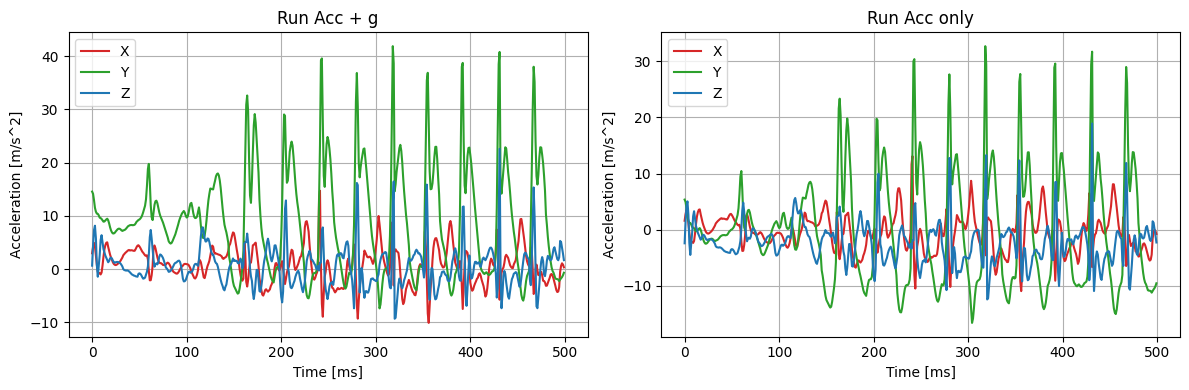

In [15]:
import matplotlib.pyplot as plt

label, accs = run_over_row(probes["Run"], acc_g_separation)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(accs[:, 0], "tab:red", label="X")
ax1.plot(accs[:, 1], "tab:green", label="Y")
ax1.plot(accs[:, 2], "tab:blue", label="Z")
ax1.set_title(f"{labels_dict[label]} Acc + g")
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Acceleration [m/s^2]")
ax1.grid()
ax1.legend()

ax2.plot(accs[:, 3], "tab:red", label="X")
ax2.plot(accs[:, 4], "tab:green", label="Y")
ax2.plot(accs[:, 5], "tab:blue", label="Z")
ax2.set_title(f"{labels_dict[label]} Acc only")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Acceleration [m/s^2]")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show() 

o s t r o ż n i e - liczyło się u mnie ok. 20 minut

In [ ]:
resultsAccs = run_over_dataset(acc_g_separation)

Mean of means


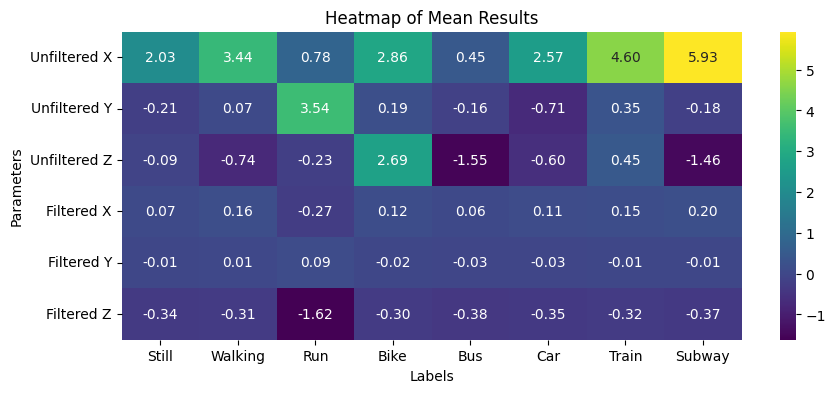

Mean of medians


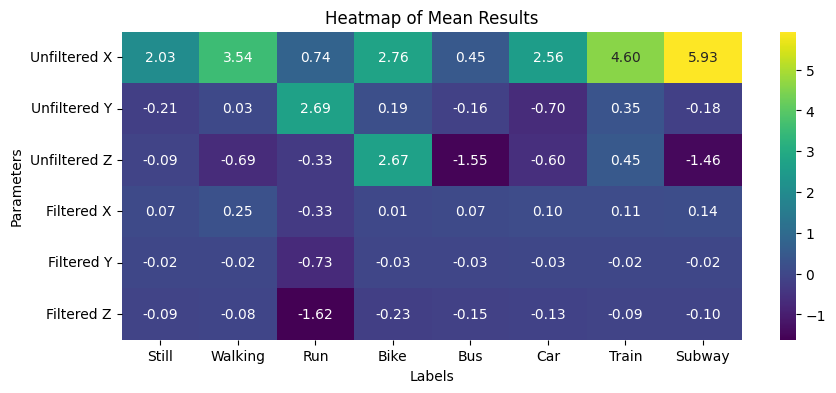

Mean of std


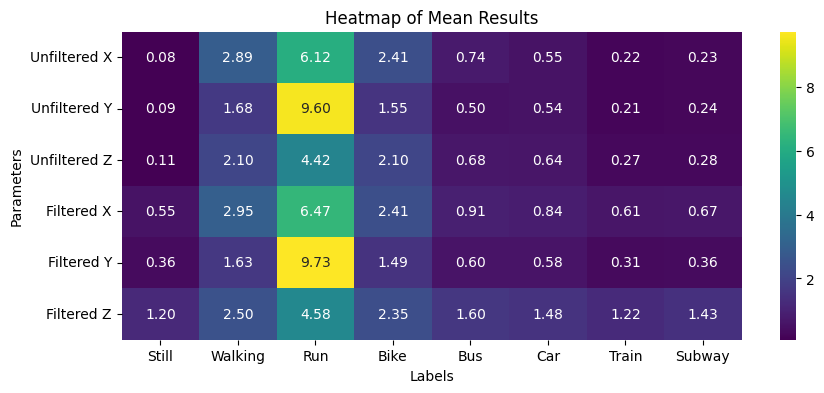

Mean of max


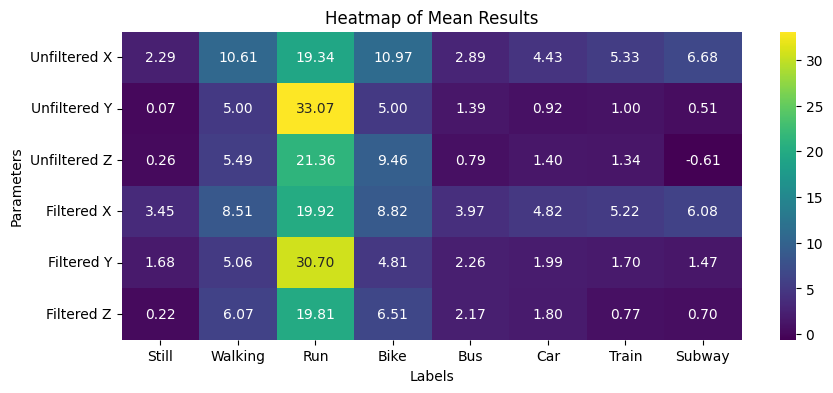

Mean of min


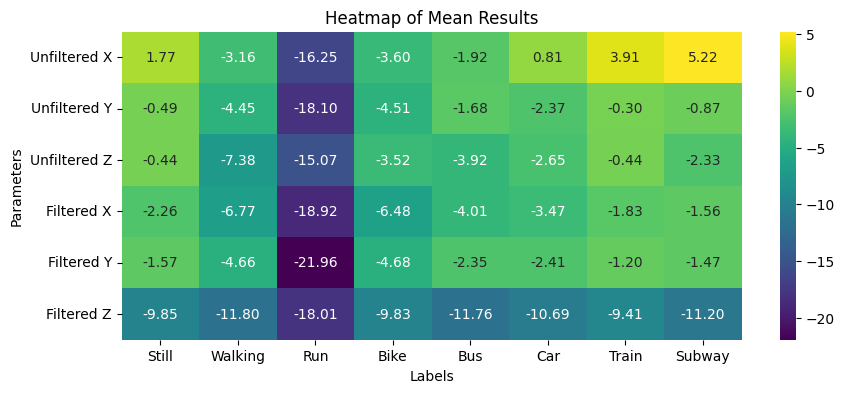

In [137]:
print("Mean of means")
heatmap_of(resultsAccs, np.mean, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])
print("Mean of medians")
heatmap_of(resultsAccs, np.median, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])
print("Mean of std")
heatmap_of(resultsAccs, np.std, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])
print("Mean of max")
heatmap_of(resultsAccs, np.max, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])
print("Mean of min")
heatmap_of(resultsAccs, np.min, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])

### IMU Fusion + SMV

wszystkie dane do jednego

In [21]:
import imufusion
from scipy.spatial.transform import Rotation as R
import math


def imu_smv_separation(labels, sensors):
    fs = 1/100
    recording_length = 500

    imu_smv = np.empty((recording_length, 1))
    ahrs = imufusion.Ahrs()

    acc = np.concatenate((mirror_me(sensors["Acc_x"].reshape(500, 1)), mirror_me(sensors["Acc_y"].reshape(500, 1)), mirror_me(sensors["Acc_z"].reshape(500, 1))), axis=1)
    gyr = np.concatenate((mirror_me(sensors["Gyr_x"].reshape(500, 1)), mirror_me(sensors["Gyr_y"].reshape(500, 1)), mirror_me(sensors["Gyr_z"].reshape(500, 1))), axis=1)
    mag = np.concatenate((mirror_me(sensors["Mag_x"].reshape(500, 1)), mirror_me(sensors["Mag_y"].reshape(500, 1)), mirror_me(sensors["Mag_z"].reshape(500, 1))), axis=1)
    
    last_rot = R.from_quat([0,0,0,1])

    for index in range(recording_length * 2):
        ahrs.update(gyr[index], acc[index], mag[index], fs)

        q = [ahrs.quaternion.x, ahrs.quaternion.y, ahrs.quaternion.z, ahrs.quaternion.w]
        try:
            rotation = R.from_quat(q)
        except:
            print("Wrong quat", q, "assuming previous rotation", last_rot)
            rotation = last_rot
        gravity = rotation.inv().apply([0, 0, 9.81])
        linear_acc = acc[index] - gravity

        if index >= recording_length:
            imu_smv[index - recording_length] = math.sqrt(linear_acc[0]**2 + linear_acc[1]**2 + linear_acc[2]**2) 

        last_rot = rotation

    label = get_label(labels)

    return label, imu_smv

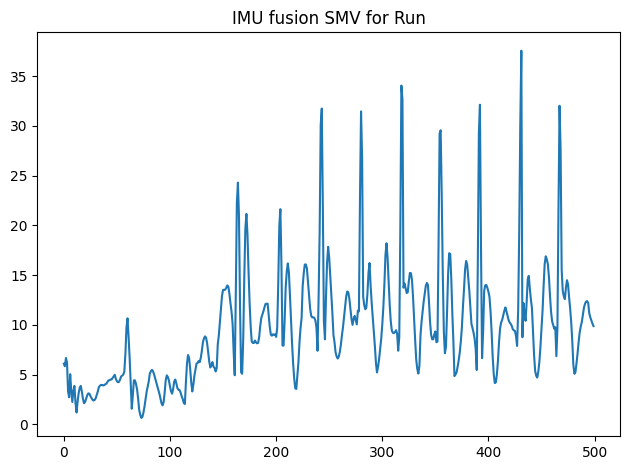

In [33]:
import matplotlib.pyplot as plt

label, imu_smv = run_over_row(probes["Run"], imu_smv_separation)

plt.plot(imu_smv)
plt.title(f"IMU fusion SMV for {labels_dict[label]}")
plt.ylabel("")

plt.tight_layout()
plt.show() 

#### SMV (Signal Magnitude Vector)
https://arxiv.org/html/2407.11048v1

In [56]:
import math

def calculate_smv(labels, sensors, modality):

    recording_length = 500
    smv = np.empty((recording_length, 1))

    data = None

    if modality == "acc": data = np.concatenate((sensors["Acc_x"].reshape(500, 1) / 9.81, sensors["Acc_y"].reshape(500, 1) / 9.81, sensors["Acc_z"].reshape(500, 1) / 9.81), axis=1)
    elif modality == "gyr": data  = np.concatenate((sensors["Gyr_x"].reshape(500, 1) / (2 * math.pi), sensors["Gyr_y"].reshape(500, 1) / (2 * math.pi), sensors["Gyr_z"].reshape(500, 1) / (2 * math.pi)), axis=1)
    elif modality == "mag": data  = np.concatenate((sensors["Mag_x"].reshape(500, 1) / 100, sensors["Mag_y"].reshape(500, 1) / 100, sensors["Mag_z"].reshape(500, 1) / 100), axis=1)
    else: 
        pass


    for index in range(recording_length):
        smv[index] = math.sqrt(data[index][0]**2 + data[index][1]**2 + data[index][2]**2)

    label = get_label(labels)

    return label, smv

Test for acc

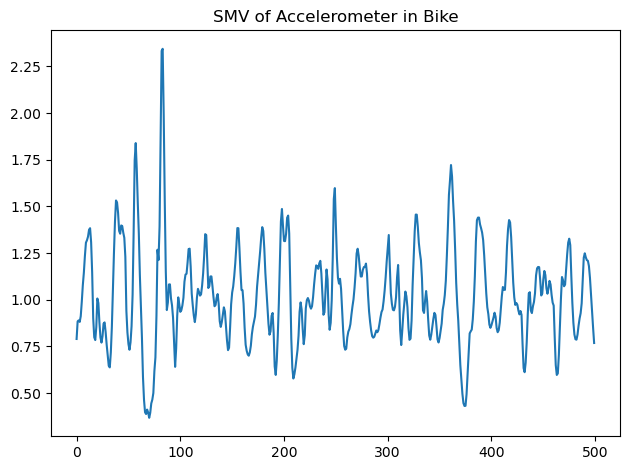

In [57]:
from functools import partial
import matplotlib.pyplot as plt

calculate_smv_acc = partial(calculate_smv, modality="acc")

label, smv = run_over_row(15, calculate_smv_acc)

plt.plot(smv)
plt.title(f"SMV of Accelerometer in {labels_dict[label]}")

plt.tight_layout()
plt.show() 

In [44]:
resultsSMV = run_over_dataset(calculate_smv_acc)

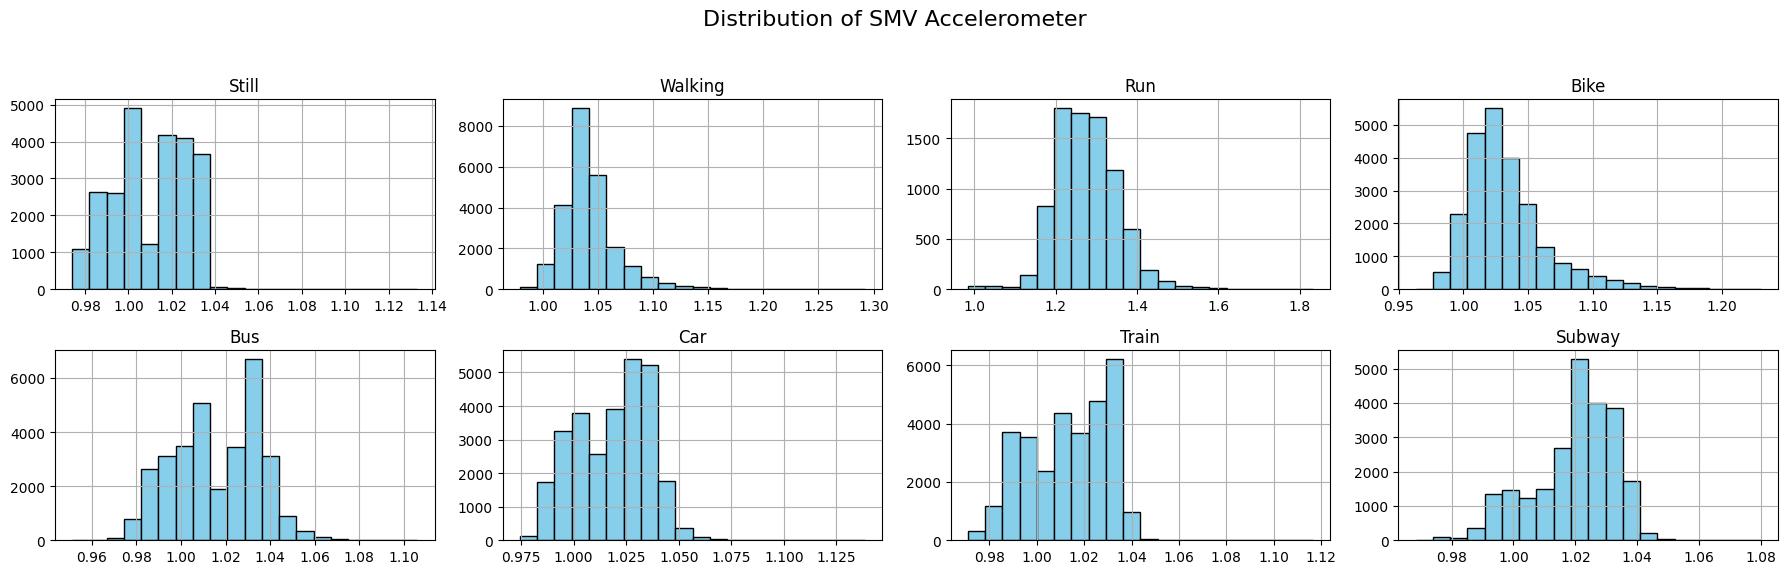

In [45]:
histograms_of(resultsSMV, np.mean, "SMV Accelerometer")

#### Gradienty

In [83]:
import math

def calculate_gradients(labels, sensors, modality, derivative_order=0):

    recording_length = 500
    smv = np.empty((recording_length, 1))
    
    data = None

    if modality == "acc": data = np.concatenate((sensors["Acc_x"].reshape(500, 1) / 9.81, sensors["Acc_y"].reshape(500, 1) / 9.81, sensors["Acc_z"].reshape(500, 1) / 9.81), axis=1)
    elif modality == "gyr": data  = np.concatenate((sensors["Gyr_x"].reshape(500, 1) / (2 * math.pi), sensors["Gyr_y"].reshape(500, 1) / (2 * math.pi), sensors["Gyr_z"].reshape(500, 1) / (2 * math.pi)), axis=1)
    elif modality == "mag": data  = np.concatenate((sensors["Mag_x"].reshape(500, 1) / 100, sensors["Mag_y"].reshape(500, 1) / 100, sensors["Mag_z"].reshape(500, 1) / 100), axis=1)
    else: 
        pass

    for index in range(recording_length):
        smv[index] = math.sqrt(data[index][0]**2 + data[index][1]**2 + data[index][2]**2)

    if derivative_order == 1:
        smv = np.gradient(smv[:, 0])[:, np.newaxis]
    elif derivative_order == 2:
        first_derivative = np.gradient(smv[:, 0])
        smv = np.gradient(first_derivative)[:, np.newaxis]

    label = get_label(labels)

    return label, smv

testy

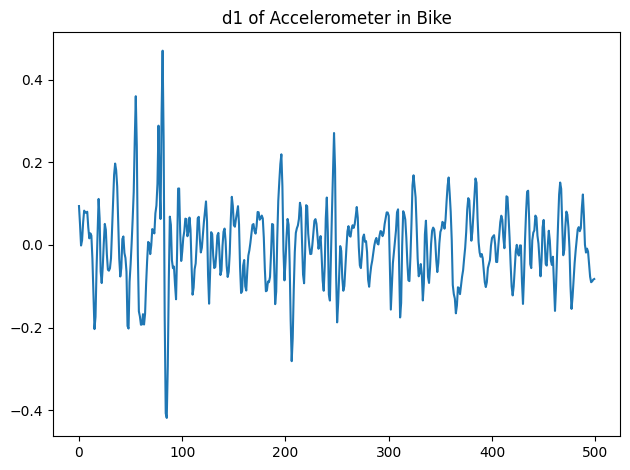

In [111]:
from functools import partial
import matplotlib.pyplot as plt

calculate_dt1_acc = partial(calculate_gradients, modality="acc", derivative_order=1)

label, dt1 = run_over_row(15, calculate_dt1_acc)

plt.plot(dt1)
plt.title(f"d1 of Accelerometer in {labels_dict[label]}")

plt.tight_layout()
plt.show() 

In [85]:
resultsDt1 = run_over_dataset(calculate_dt1_acc)

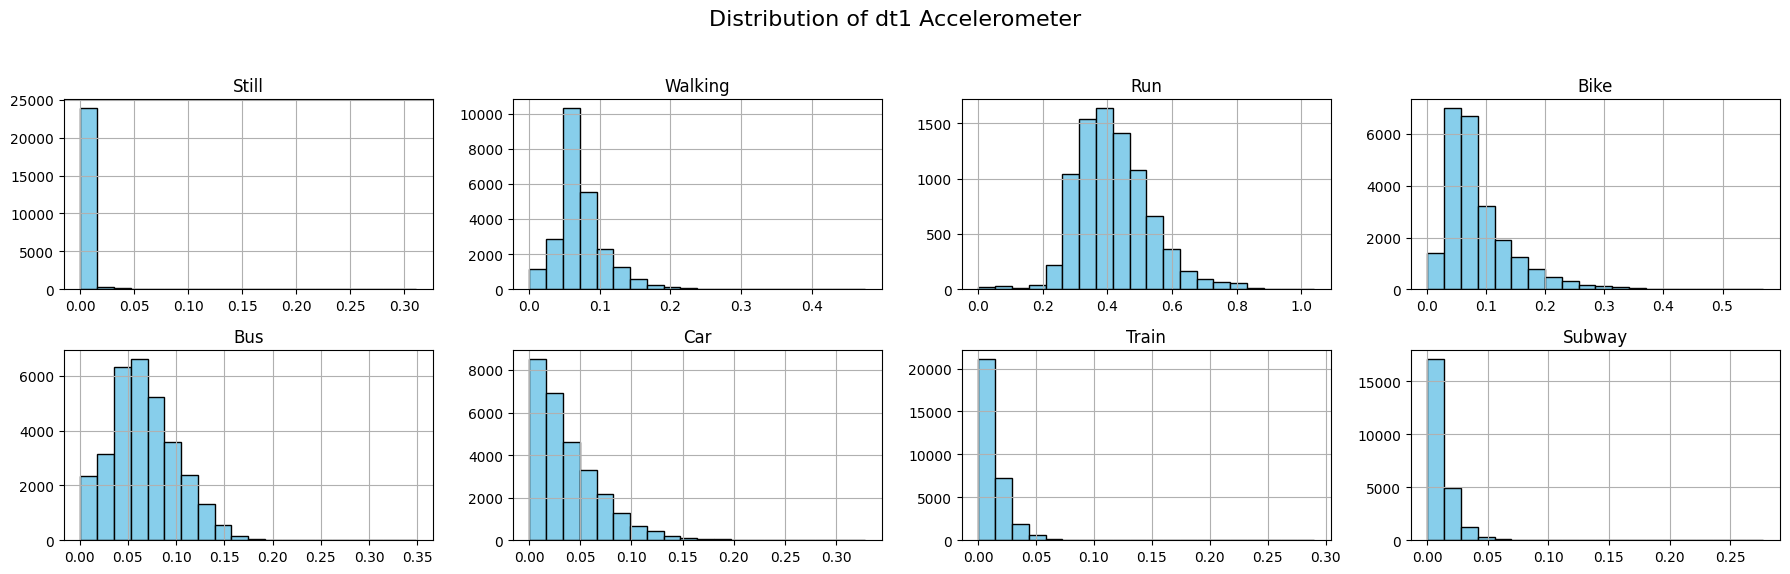

In [88]:
histograms_of(resultsDt1, np.std, "dt1 Accelerometer")

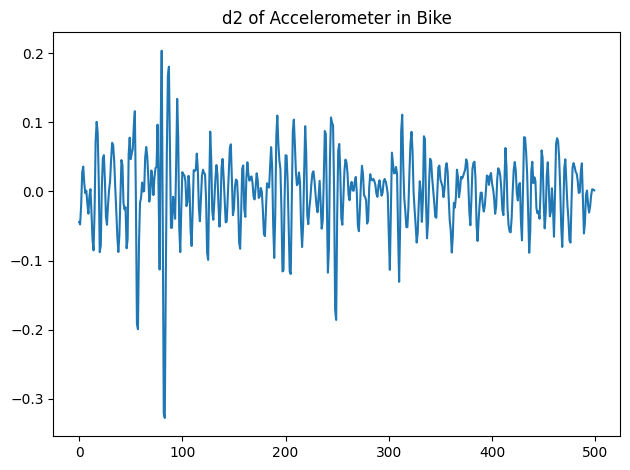

In [112]:
from functools import partial
import matplotlib.pyplot as plt

calculate_dt2_acc = partial(calculate_gradients, modality="acc", derivative_order=2)

label, dt2 = run_over_row(15, calculate_dt2_acc)

plt.plot(dt2)
plt.title(f"d2 of Accelerometer in {labels_dict[label]}")

plt.tight_layout()
plt.show() 

In [90]:
resultsDt2 = run_over_dataset(calculate_dt2_acc)

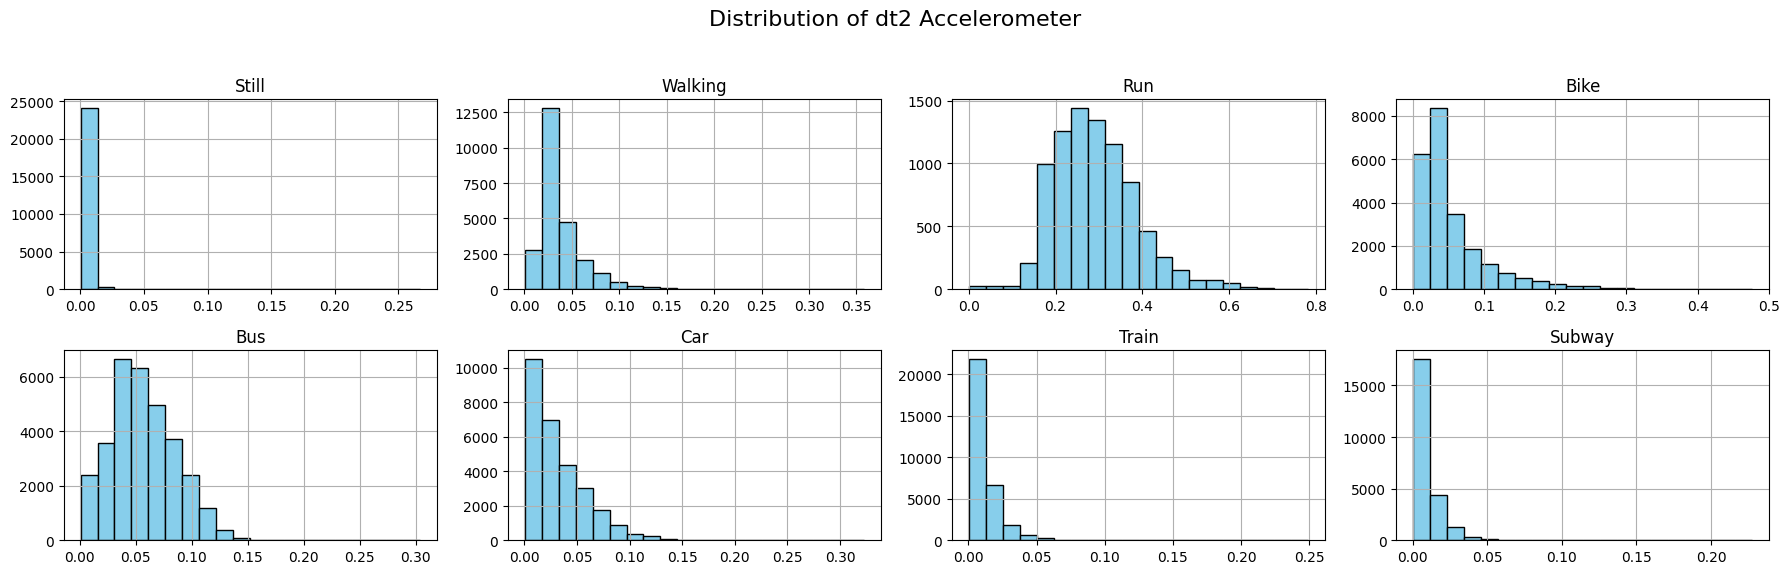

In [91]:
histograms_of(resultsDt2, np.std, "dt2 Accelerometer")

Całka

In [101]:
import math
import scipy.integrate as sp

def calculate_integral(labels, sensors, modality):

    recording_length = 500
    smv = np.empty((recording_length, 1))
    
    data = None

    if modality == "acc": data = np.concatenate((sensors["Acc_x"].reshape(500, 1) / 9.81, sensors["Acc_y"].reshape(500, 1) / 9.81, sensors["Acc_z"].reshape(500, 1) / 9.81), axis=1)
    elif modality == "gyr": data  = np.concatenate((sensors["Gyr_x"].reshape(500, 1) / (2 * math.pi), sensors["Gyr_y"].reshape(500, 1) / (2 * math.pi), sensors["Gyr_z"].reshape(500, 1) / (2 * math.pi)), axis=1)
    elif modality == "mag": data  = np.concatenate((sensors["Mag_x"].reshape(500, 1) / 100, sensors["Mag_y"].reshape(500, 1) / 100, sensors["Mag_z"].reshape(500, 1) / 100), axis=1)
    else: 
        pass

    for index in range(recording_length):
        smv[index] = math.sqrt(data[index][0]**2 + data[index][1]**2 + data[index][2]**2)

    smv = sp.trapezoid(smv[:, 0], dx = 0.01)

    label = get_label(labels)

    return label, smv

testy

In [103]:
from functools import partial
import matplotlib.pyplot as plt

calculate_integral_acc = partial(calculate_integral, modality="acc")

label, integral = run_over_row(15, calculate_integral_acc)

print(integral)

5.100120754183294


In [104]:
resultsIntegral = run_over_dataset(calculate_integral_acc)

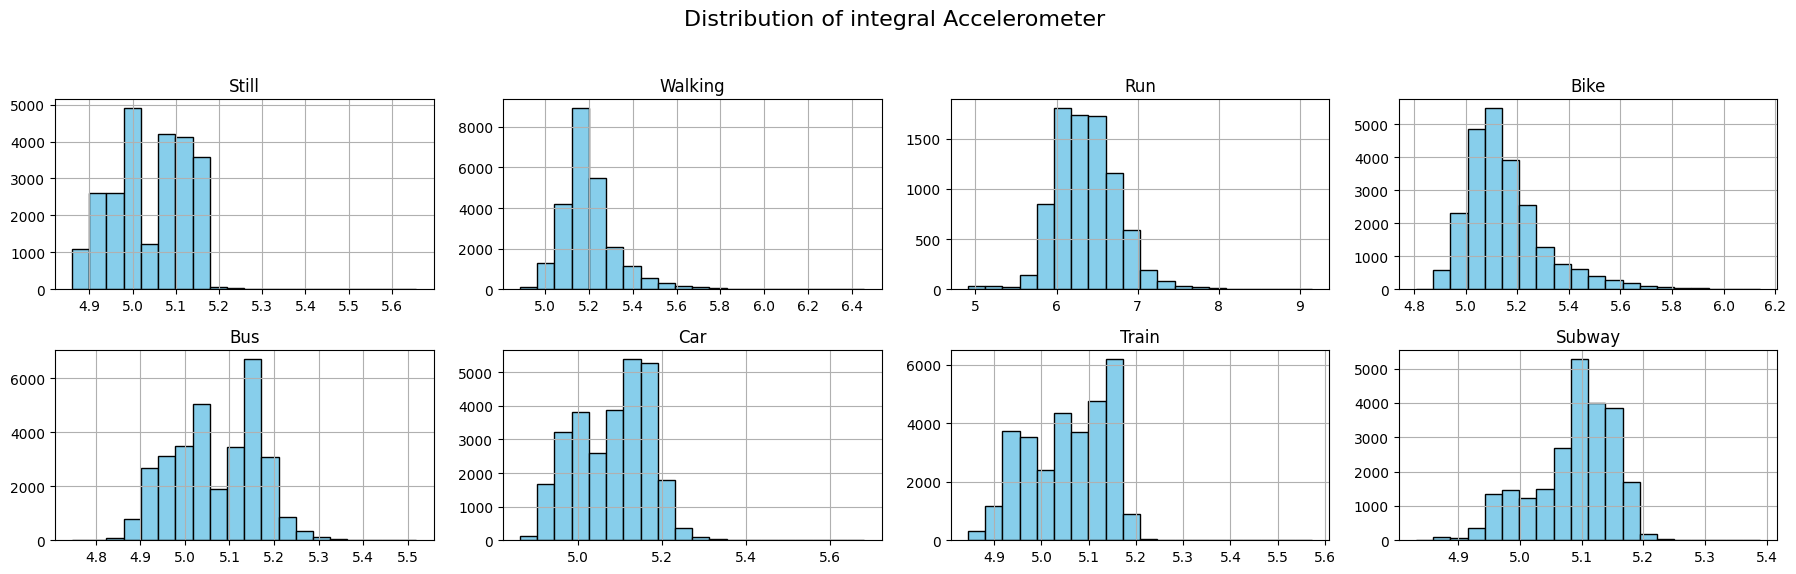

In [110]:
histograms_of(resultsIntegral, np.std, "integral Accelerometer")

#### Angle i Angle of deviation
https://dl.acm.org/doi/pdf/10.1145/3675094.3678461

In [53]:
import math

def calculate_angle(labels, sensors, modality, axes):
    axes_dict = {"X": 0, "Y": 1, "Z": 2}
    recording_length = 500
    angles = np.empty((recording_length, 1))

    data = None

    if modality == "acc": data = np.concatenate((sensors["Acc_x"].reshape(500, 1) / 9.81, sensors["Acc_y"].reshape(500, 1) / 9.81, sensors["Acc_z"].reshape(500, 1) / 9.81), axis=1)
    elif modality == "gyr": data  = np.concatenate((sensors["Gyr_x"].reshape(500, 1) / (2 * math.pi), sensors["Gyr_y"].reshape(500, 1) / (2 * math.pi), sensors["Gyr_z"].reshape(500, 1) / (2 * math.pi)), axis=1)
    elif modality == "mag": data  = np.concatenate((sensors["Mag_x"].reshape(500, 1) / 100, sensors["Mag_y"].reshape(500, 1) / 100, sensors["Mag_z"].reshape(500, 1) / 100), axis=1)
    else: 
        pass


    for index in range(recording_length):
        mi = data[index][axes_dict[axes[0]]]
        mj = data[index][axes_dict[axes[1]]]
        angles[index] = math.copysign(1, mj) * math.acos(mi/math.sqrt((mi**2 + mj**2)))
    

    label = get_label(labels)

    return label, angles

Test for acc X, Y

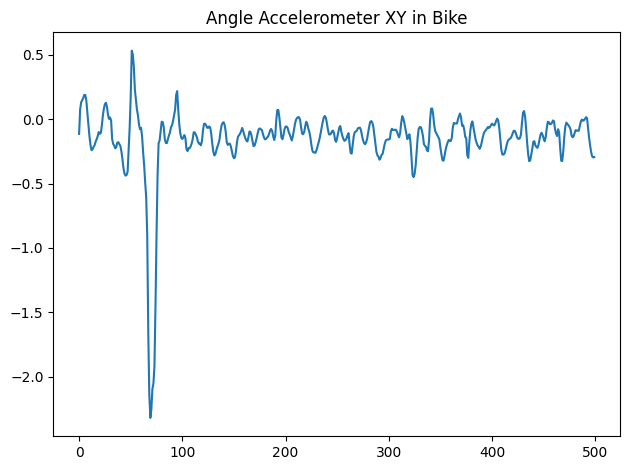

In [65]:
from functools import partial
import matplotlib.pyplot as plt

calculate_ang_acc = partial(calculate_angle, modality="acc", axes=["X", "Y"])

label, angles = run_over_row(15, calculate_ang_acc)

plt.plot(angles)
plt.title(f"Angle Accelerometer XY in {labels_dict[label]}")

plt.tight_layout()
plt.show() 

In [66]:
resultsAngleAccXY = run_over_dataset(calculate_ang_acc)

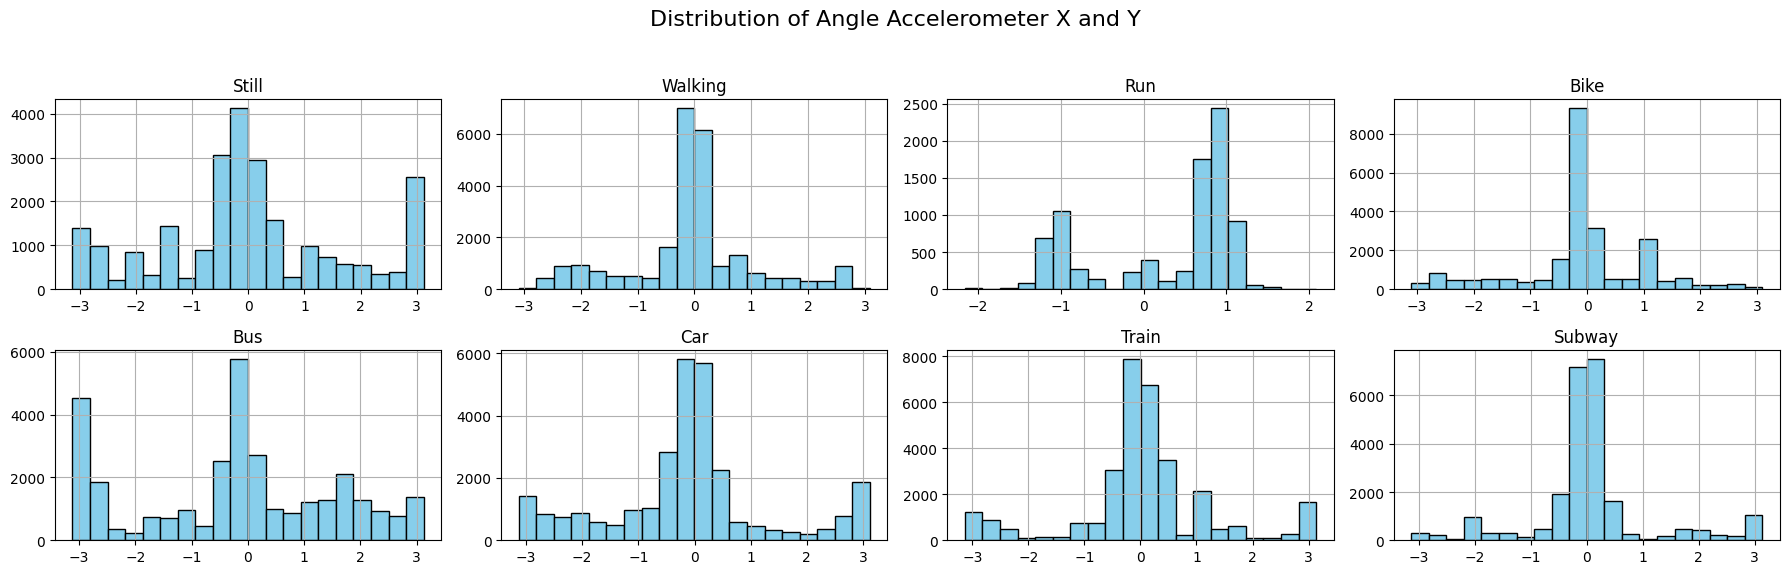

In [79]:
histograms_of(resultsAngleAccXY, np.mean, "Angle Accelerometer X and Y")

In [74]:
import math

def calculate_angle_of_deviation(labels, sensors, axes):
    
    recording_length = 500

    angles = np.empty((recording_length, 1))

    label, acc = calculate_angle(labels, sensors, "acc", axes)
    _, gyr = calculate_angle(labels, sensors, "gyr", axes)

    for index in range(recording_length):
        angles[index] = abs(acc[index] - gyr[index])

    return label, angles

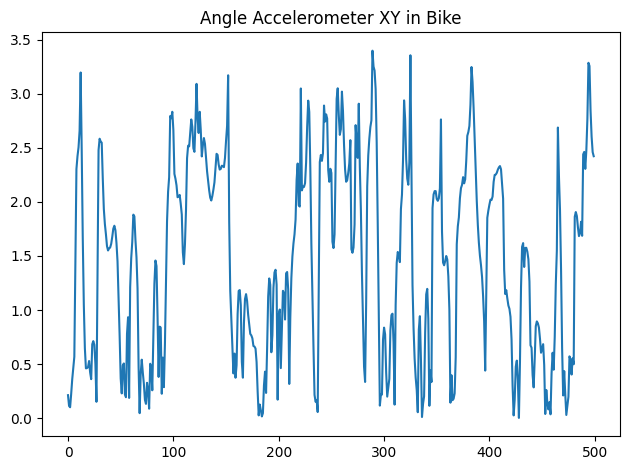

In [75]:
from functools import partial
import matplotlib.pyplot as plt

calculate_ang_of_dev_acc = partial(calculate_angle_of_deviation, axes=["X", "Y"])

label, angles = run_over_row(15, calculate_ang_of_dev_acc)

plt.plot(angles)
plt.title(f"Angle Accelerometer XY in {labels_dict[label]}")

plt.tight_layout()
plt.show()

In [76]:
resultsAngleOfDeviationXY = run_over_dataset(calculate_ang_of_dev_acc)

C:\Users\Ryszard\AppData\Local\Temp\ipykernel_23564\2715510572.py:20: RuntimeWarning: invalid value encountered in scalar divide
  angles[index] = math.copysign(1, mj) * math.acos(mi/math.sqrt((mi**2 + mj**2)))


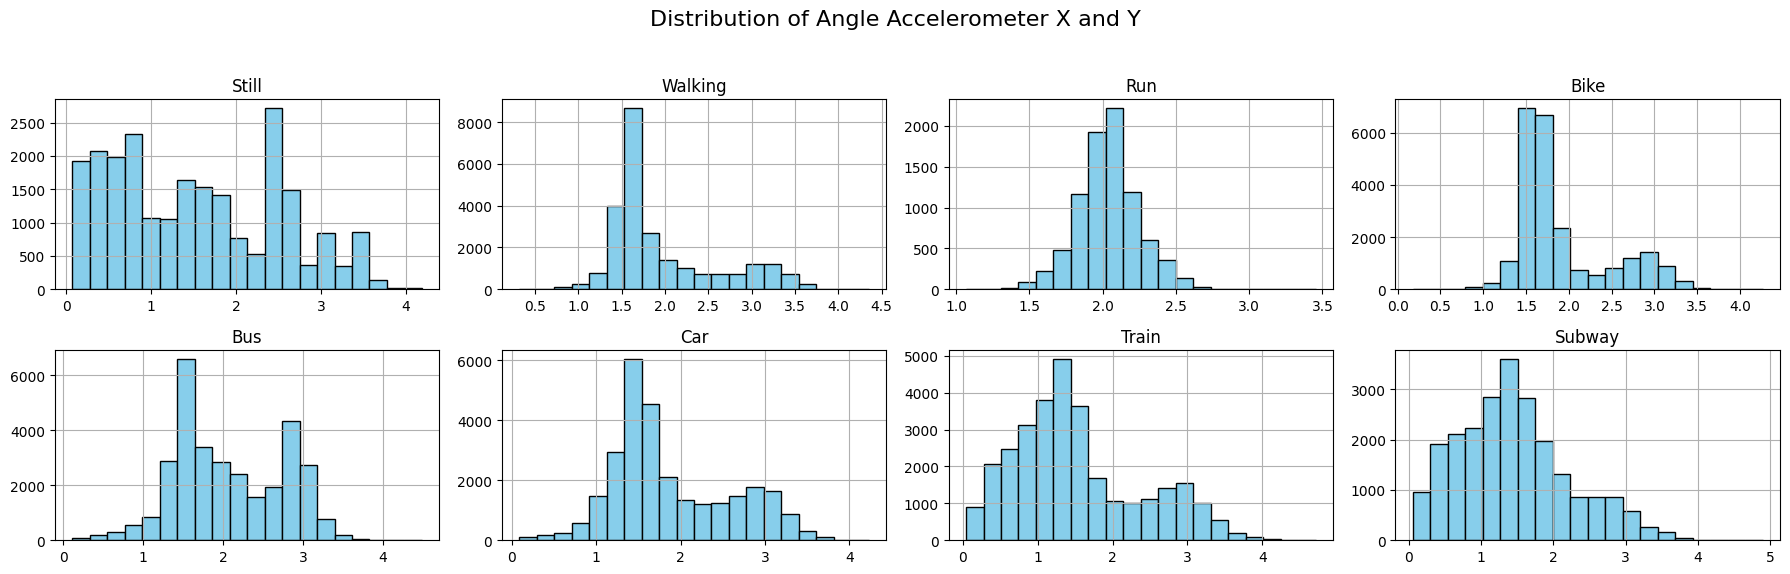

In [77]:
histograms_of(resultsAngleOfDeviationXY, np.mean, "Angle Accelerometer X and Y")